# Actividad 4
#### completar los TODOs

In [46]:
import random
import math
import time
import copy
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.nn.utils import clip_grad_norm_
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
class CorpusDataset(torch.utils.data.Dataset):
    
    FREQUENCY_THRESHOLD = 2
    VOCAB_SIZE = 50000
    PAD_TOKEN = "<pad>"
    START_TOKEN = "<s>"
    END_TOKEN = "</s>"
    UNKNOWN_TOKEN = "<unk>"
    
    def __init__(self, path, src, dst, src_token2id=None, src_id2token=None, dst_token2id=None, dst_id2token=None):
        assert src in ("es", "en")
        assert dst != src and dst in ("es", "en")
        
        self.src_sentences = self._load_sentences(path, src)
        self.dst_sentences = self._load_sentences(path, dst)
        assert len(self.src_sentences) == len(self.dst_sentences)
        
        if src_token2id is None and src_id2token is None and dst_token2id is None and dst_id2token is None:
            self.src_token2id, self.src_id2token = self._build_token2id(self.src_sentences)
            self.dst_token2id, self.dst_id2token = self._build_token2id(self.dst_sentences)
        else:
            self.src_token2id, self.src_id2token = src_token2id, src_id2token
            self.dst_token2id, self.dst_id2token = dst_token2id, dst_id2token
    
    def _load_sentences(self, path, lang):
        path = path + ".{}".format(lang)
        with open(path, "r") as corpus_file:
            sentences = [line.strip().split(" ") for line in corpus_file]
        return sentences
    
    def _build_token2id(self, sentences):
        """
        [TODO] Debe implementar este método.
        Recibe como parámetros una lista con listas de tokens de una oración.
        Se debe retornar:
            - `token2id`: un diccionario con el vocabulario correspondiente a las VOCAB_SIZE palabras
                más frecuentes que cumplan con tener una frecuencia mayor o igual a FREQUENCY_THRESHOLD.
                Cada llave es un token asociado a un identificador único entero.
            - `id2token`: un diccionario con el mismo vocabulario de `token2id`, pero esta vez cada llave
                el es identificador único asociado al respectivo token.
                
        IMPORTANTE: debe agregar al principio del vocabulario los tokens especiales self.PAD_TOKEN,
            self.START_TOKEN, self.END_TOKEN y self.UNKNOWN_TOKEN, que quedarán con los identificadores
            0, 1, 2 y 3 respectivamente. Por lo tanto, el vocabulario puede quedar con un tamaño máximo
            de VOCAB_SIZE + 4 elementos.
            
        """
        
        token2count = dict()
        for sentence in sentences:
            for token in sentence:
                token2count[token] = token2count.get(token, 0) + 1
        pairs = list(token2count.items())
        pairs.sort(key=lambda p:p[1], reverse=True)
        id2token = [self.PAD_TOKEN, self.START_TOKEN, self.END_TOKEN, self.UNKNOWN_TOKEN]
        id2token.extend(pairs[i][0] for i in range(self.VOCAB_SIZE))
        token2id = { token:_id for _id, token in enumerate(id2token) }
        
        return token2id, id2token

    def _tokens2ids(self, token2id, tokens, is_target=False):
        ids = []
        for token in tokens:
            if token in token2id:
                ids.append(token2id[token])
            else:
                ids.append(token2id[self.UNKNOWN_TOKEN])
        if is_target:
            ids.insert(0, token2id[self.START_TOKEN])
            ids.append(token2id[self.END_TOKEN])
        return ids
    
    def __getitem__(self, idx):
        src_tokens, dst_tokens = self.src_sentences[idx], self.dst_sentences[idx]
        src_ids, dst_ids = self._tokens2ids(self.src_token2id, src_tokens), self._tokens2ids(self.dst_token2id, dst_tokens, is_target=True)
        return {
            "src": src_ids,
            "dst": dst_ids
        }
    
    def __len__(self):
        return len(self.src_sentences)
    
    def ids2tokens(self, id2token, ids):
        tokens = [id2token[id] for id in ids]
        return " ".join(tokens)

In [3]:
TRAIN_PATH = "./en_es_data/train"
TEST_PATH = "./en_es_data/test"
DEV_PATH = "./en_es_data/dev"

train_dataset = CorpusDataset(
    path=TRAIN_PATH,
    src="en",
    dst="es")
dev_dataset = CorpusDataset(
    path=DEV_PATH,
    src="en",
    dst="es",
    src_token2id=train_dataset.src_token2id,
    src_id2token=train_dataset.src_id2token,
    dst_token2id=train_dataset.dst_token2id,
    dst_id2token=train_dataset.dst_id2token)
test_dataset = CorpusDataset(
    path=TEST_PATH,
    src="en",
    dst="es",
    src_token2id=train_dataset.src_token2id,
    src_id2token=train_dataset.src_id2token,
    dst_token2id=train_dataset.dst_token2id,
    dst_id2token=train_dataset.dst_id2token)

BATCH_SIZE = 32

In [4]:
def collate_sentences(batch):
    """
    Esta función permite construir lotes de pares de oraciones en lenguaje de origen y objetivo.
    Al utilizar secuencias, en este caso oraciones, de largo variable en redes recurrentes es necesario
    empaquetarlas para hacer cálculos eficientes en PyTorch. En esta tarea particular, solo se
    necesita empaquetar las oraciones de entrada. Para empaquetar secuencias, es requisito que estén
    ordenadas de acuerdo a su largo en forma decreciente.
    
    Si se desea profundizar:
        https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.pack_padded_sequence
        https://stackoverflow.com/questions/51030782/why-do-we-pack-the-sequences-in-pytorch
    """
    src = []
    dst = []
    for item in batch:
        src.append(torch.tensor(item["src"]))
        dst.append(torch.tensor(item["dst"]))
    src_dst_zipped = list(zip(src, dst))
    src_dst_zipped.sort(key=lambda x: len(x[0]), reverse=True)
    
    batch_dict = {
        "src": [],
        "dst": [],
        "src_lengths": [],
        "dst_lengths": []
    }
    
    for pair in src_dst_zipped:
        batch_dict["src"].append(pair[0])
        batch_dict["src_lengths"].append(len(pair[0]))
        batch_dict["dst"].append(pair[1])
        batch_dict["dst_lengths"].append(len(pair[1]))
        
    
    for elem in ("src", "dst"):
        lengths_name = "%s_lengths" % elem
        batch_dict[lengths_name] = torch.tensor(batch_dict[lengths_name])
        batch_dict[elem] = nn.utils.rnn.pad_sequence(
            sequences=batch_dict[elem],
            batch_first=True,
            padding_value=0)
        
    return batch_dict

In [5]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_sentences)
dev_dataloader = DataLoader(
    dev_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_sentences)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_sentences)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
dataloaders = dict(
    train=train_dataloader,
    dev=dev_dataloader,
    test=test_dataloader,
)

In [7]:
class _EncoderModule(nn.Module):
    def __init__(self, embeddings_table, embeddings_size, hidden_size):
        super().__init__()
        
        self.embeddings_table = embeddings_table
        self.embeddings_size = embeddings_size
        self.hidden_size = hidden_size
        
        """
        [TODO] Inicializar los siguientes atributos:
            self.lstm: LSTM bidireccional con bias
        
        Documentación relevante:
            https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
        """
        
        self.lstm = nn.LSTM(
            input_size=embeddings_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )        
        
        
    def forward(self, src_sentences, src_lengths):
        """
        Args:
            - src_sentences: un tensor con forma [batch_sz, max_src_sentence_length].
            - src_lengths: un tensor con forma [batch_sz].
        Returns:
            - all_hidden_states: un tensor con forma [batch_sz, max_src_sentence_length, 2 * hidden_size]
                Son los h^{enc}_i del enunciado.
            - hidden_states: un tensor con forma [2, batch_sz, hidden_size].
                Son los h^{enc} finales de la pasada hacia delante y hacia atrás de la LSTM bidireccional.
            - cell_states: un tensor con forma [2, batch_sz, hidden_size].
                Son los c^{enc} finales de la pasada hacia delante y hacia atrás de la LSTM bidireccional.
            
        """
        
        """
        [TODO] Implemente el `forward` del codificador.
            1. Debe calcular los embeddings de las oraciones.
            2. Debe empacar las secuencias de embeddings.
            3. Debe pasar la secuencia empacada por la LSTM bidireccional.
            4. Debe rellenar los estados ocultos empaquetados retornados por la LSTM.
        
        Documentación relevante:
            https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.pack_padded_sequence
            https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.pad_packed_sequence
        """
        embedded_sentences = self.embeddings_table(src_sentences)
        packed_sentences = pack_padded_sequence(embedded_sentences,
                                                src_lengths,
                                                batch_first=True)
        
        batch_size, max_src_sentence_length = src_sentences.shape
        
        assert max_src_sentence_length == src_lengths.max()
        
        h0 = self.init_hidden_state(batch_size)
        c0 = self.init_cell_state(batch_size)
        output, (hidden_states, cell_states) = self.lstm(packed_sentences, (h0, c0))
        all_hidden_states, _ = pad_packed_sequence(output,
                                                   batch_first=True,
                                                   padding_value=0,
                                                   total_length=max_src_sentence_length)

        assert all_hidden_states.shape == (batch_size, max_src_sentence_length, 2 * self.hidden_size)
        assert hidden_states.shape == (2, batch_size, self.hidden_size)
        assert cell_states.shape == (2, batch_size, self.hidden_size)
        
        return all_hidden_states, hidden_states, cell_states
    
    def init_hidden_state(self, batch_size):
        return torch.zeros(2, batch_size, self.hidden_size).to(DEVICE)
    
    def init_cell_state(self, batch_size):
        return torch.zeros(2, batch_size, self.hidden_size).to(DEVICE)

class _DecoderModule(nn.Module):
    def __init__(
            self,
            embeddings_table,
            embeddings_size,
            hidden_size,
            start_idx,
            dropout_prob,
            dst_vocab_size
        ):
        super().__init__()
        
        self.embeddings_table = embeddings_table
        self.embeddings_size = embeddings_size
        self.hidden_size = hidden_size
        self.start_idx = torch.tensor(start_idx).to(DEVICE)
        self.dst_vocab_size = dst_vocab_size
        
        """
        [TODO] Inicializar los siguientes atributos:
            self.W_h: capa lineal sin bias.
            self.W_c: capa lineal sin bias.
            self.lstm_cell: celda LSTM con bias.
            self.W_attn: capa lineal sin bias.
            self.W_u: capa lineal sin bias.
            self.dropout: capa de dropout.
            self.W_vocab: capa lineal sin bias.
        
        Documentación relevante:
            https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
            https://pytorch.org/docs/stable/nn.html#torch.nn.LSTMCell
            https://pytorch.org/docs/stable/nn.html#torch.nn.Linear
            https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout
        """        
        self.W_h = nn.Linear(2 * hidden_size, hidden_size, bias=False)
        self.W_c = nn.Linear(2 * hidden_size, hidden_size, bias=False)
        self.lstm_cell = nn.LSTMCell(input_size=embeddings_size+hidden_size,
                                     hidden_size=hidden_size,
                                     bias=True)
        self.W_attn = nn.Linear(2 * hidden_size, hidden_size, bias=False)
        self.W_u = nn.Linear(3 * hidden_size, hidden_size, bias=False)
        self.dropout = nn.Dropout(dropout_prob)
        self.W_vocab = nn.Linear(hidden_size, dst_vocab_size)
        
        
    def forward(
            self,
            all_enc_hidden_states,
            final_enc_hidden_states,
            final_enc_cell_states,
            dst_sentences,
            dst_lengths,            
        ):
        """
        Args:
            - all_enc_hidden_states: un tensor con forma [batch_sz, max_sent_length, 2 * hidden_size].
            - final_enc_hidden_states: un tensor con forma [2, batch_sz, hidden_size].
            - final_enc_cell_states: un tensor con forma [2, batch_sz, hidden_size].
            - max_sentence_length: un int con el largo máximo de las oraciones en el lenguaje objetivo.
        Returns:
            - output: un tensor con forma [batch_sz, max_sent_length, dst_vocab_size]. Corresponde al tensor
                DENTRO DE LA FUNCIÓN SOFTMAX en la ecuación donde se define P_t.
        """
        
        """
        [TODO] Implemente el `forward` del decodificador. Recuerde:
            - debe inicializar los vectores que se indican en el enunciado.
            - retorne el tensor DENTRO DE LA FUNCIÓN SOFTMAX de la ecuación donde se define P_t, esto
                es importante debido a que la función de pérdida (i.e. CrossEntropyLoss) aplica la
                función softmax para tener mejor estabilidad numérica.
                
        Documentación relevante:
            https://pytorch.org/docs/stable/torch.html#torch.zeros
            https://pytorch.org/docs/stable/torch.html#torch.unsqueeze
            https://pytorch.org/docs/stable/torch.html#torch.cat
            https://pytorch.org/docs/stable/torch.html#torch.sum
            https://pytorch.org/docs/stable/torch.html#torch.argmax
            https://pytorch.org/docs/stable/torch.html#torch.stack
        """
        max_sentence_length = dst_lengths.max()
        batch_size = all_enc_hidden_states.shape[0]
        y = self.embeddings_table(self.start_idx).expand(batch_size, -1)
        o = torch.zeros(batch_size, self.hidden_size).to(DEVICE)
        h = self.W_h(torch.cat((final_enc_hidden_states[0],
                                final_enc_hidden_states[1]),1))  # h0_dec
        c = self.W_c(torch.cat((final_enc_cell_states[0],
                                final_enc_cell_states[1]),1))  # c0_dec
        sentence_embeddings = self.embeddings_table(dst_sentences.permute(1,0))
        assert sentence_embeddings.shape == (max_sentence_length, batch_size, self.embeddings_size)
        
        output = []
        
        for t in range(max_sentence_length):
            y_bar = torch.cat((y,o),1)
            assert y_bar.shape == (batch_size, self.embeddings_size + self.hidden_size)
            assert h.shape == (batch_size, self.hidden_size)
            assert c.shape == (batch_size, self.hidden_size)
            h, c = self.lstm_cell(y_bar, (h, c))
            e = (self.W_attn(all_enc_hidden_states) * h.unsqueeze(1)).sum(-1)
            att = torch.softmax(e,-1)
            a = (all_enc_hidden_states * att.unsqueeze(2)).sum(1)
            assert a.shape == (batch_size, 2 * self.hidden_size)
            u = torch.cat((a,h),1)
            assert u.shape == (batch_size, 3 * self.hidden_size)
            v = self.W_u(u)
            o = self.dropout(torch.tanh(v))
            assert o.shape == (batch_size, self.hidden_size)
            output.append(self.W_vocab(o))
            y = sentence_embeddings[t]
        
        output = torch.stack(output, 1)
        assert output.shape == (batch_size, max_sentence_length, self.dst_vocab_size)
        return output
    
    def eval_forward(
            self,
            all_enc_hidden_states,
            final_enc_hidden_states,
            final_enc_cell_states,
            dst_lengths,
        ):
        
        max_sentence_length = dst_lengths.max()
        batch_size = all_enc_hidden_states.shape[0]
        y = self.embeddings_table(self.start_idx).expand(batch_size, -1)
        o = torch.zeros(batch_size, self.hidden_size).to(DEVICE)
        h = self.W_h(torch.cat((final_enc_hidden_states[0],
                                final_enc_hidden_states[1]),1))  # h0_dec
        c = self.W_c(torch.cat((final_enc_cell_states[0],
                                final_enc_cell_states[1]),1))  # c0_dec        
        
        output = []
        
        for t in range(max_sentence_length):
            y_bar = torch.cat((y,o),1)
            assert y_bar.shape == (batch_size, self.embeddings_size + self.hidden_size)
            assert h.shape == (batch_size, self.hidden_size)
            assert c.shape == (batch_size, self.hidden_size)
            h, c = self.lstm_cell(y_bar, (h, c))
            e = (self.W_attn(all_enc_hidden_states) * h.unsqueeze(1)).sum(-1)
            att = torch.softmax(e,-1)
            a = (all_enc_hidden_states * att.unsqueeze(2)).sum(1)
            assert a.shape == (batch_size, 2 * self.hidden_size)
            u = torch.cat((a,h),1)
            assert u.shape == (batch_size, 3 * self.hidden_size)
            v = self.W_u(u)
            o = self.dropout(torch.tanh(v))
            assert o.shape == (batch_size, self.hidden_size)
            output.append(self.W_vocab(o))
            y = self.embeddings_table(torch.argmax(output[t], 1))
            assert y.shape == (batch_size, self.embeddings_size)
        
        output = torch.stack(output, 1)
        assert output.shape == (batch_size, max_sentence_length, self.dst_vocab_size)
        return output
    
class NeuralMachineTranslator(nn.Module):
    def __init__(
            self,
            src_vocab_size,
            dst_vocab_size,
            start_idx,
            embeddings_size,
            hidden_size,
            dropout_prob
        ):
        super().__init__()
        
        """
        [TODO] Inicializar los siguientes atributos:
            - self.src_embeddings_table: matriz de embeddings.
            - self.dst_embeddings_table: matriz de embeddings.
            
        Documentación relevante:
            - https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding
            
        OJO: recuerde asignar al parámetro `padding_idx` el identificador del token de relleno.
        """
        self.src_embeddings_table = nn.Embedding(
            num_embeddings=src_vocab_size,
            embedding_dim=embeddings_size,
            padding_idx=0,            
        ).to(DEVICE)
        self.dst_embeddings_table = nn.Embedding(
            num_embeddings=dst_vocab_size,
            embedding_dim=embeddings_size,
            padding_idx=0,
        ).to(DEVICE)
        
        self.encoder_module = _EncoderModule(
            embeddings_table=self.src_embeddings_table,
            embeddings_size=embeddings_size,
            hidden_size=hidden_size)
        self.decoder_module = _DecoderModule(
            embeddings_table=self.dst_embeddings_table,
            embeddings_size=embeddings_size,
            hidden_size=hidden_size,
            start_idx=start_idx,
            dropout_prob=dropout_prob,
            dst_vocab_size=dst_vocab_size)
        
    def forward(
            self,
            src_sentences,
            src_lengths,
            dst_sentences,
            dst_lengths
        ):
        """
        Args:
            - src_sentences: un tensor con forma [batch_sz, max_src_sentence_length].
                Son los identificadores de los tokens de las oraciones en el lenguaje de origen.
            - src_lengths: un tensor con forma [batch_sz].
                Son los largos de las oraciones en el lenguaje de origen.
            - dst_lengths: un tensor con forma [batch_sz].
                Son los largos de las oraciones en el lenguaje objetivo.
        Returns:
            - output: un tensor con forma [batch_sz, max_dst_sentence_length, dst_vocab_sz].
                Son las distribuciones de probabilidades sobre el vocabulario del lenguaje objetivo.
        """
        
        """
        [TODO] Implemente el `forward` del NeuralMachineTranslator de acuerdo al enunciado.
        """
        
        all_enc_hidden_states,\
        final_enc_hidden_states,\
        final_enc_cell_states = self.encoder_module(src_sentences, src_lengths)
        
        output = self.decoder_module(
            all_enc_hidden_states,
            final_enc_hidden_states,
            final_enc_cell_states,
            dst_sentences,
            dst_lengths)

        return output
    
    def eval_forward(
            self,
            src_sentences,
            src_lengths,
            dst_lengths,
        ):
        
        all_enc_hidden_states,\
        final_enc_hidden_states,\
        final_enc_cell_states = self.encoder_module(src_sentences, src_lengths)
        
        output = self.decoder_module.eval_forward(
            all_enc_hidden_states,
            final_enc_hidden_states,
            final_enc_cell_states,
            dst_lengths)

        return output

In [8]:
print("Device: ", DEVICE)

EMBEDDINGS_SIZE = 256
HIDDEN_SIZE = 256
GRADIENT_CLIPPING = 5
DECAY_PATIENCE = 5
LR_DECAY = 0.5
LR = 0.001
DROPOUT_PROB = 0.3
EPOCHS = 50

Device:  cuda


In [9]:
nmt = NeuralMachineTranslator(
    src_vocab_size=len(train_dataset.src_token2id),
    dst_vocab_size=len(train_dataset.dst_token2id),
    start_idx=train_dataset.src_token2id[train_dataset.START_TOKEN],
    embeddings_size=EMBEDDINGS_SIZE,
    hidden_size=HIDDEN_SIZE,
    dropout_prob=DROPOUT_PROB)
nmt.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nmt.parameters(), lr=LR)

In [10]:
def batch_mean_bleu_score(gt_sentences, pred_sentences, smoothing_function):
    assert gt_sentences.shape == pred_sentences.shape
    bleu = 0
    n = gt_sentences.shape[0]
    for i in range(n):
        reference = [t for t in gt_sentences[i] if t >= 4]
        hypothesis = [t for t in pred_sentences[i] if t >= 4]
        bleu += sentence_bleu((reference,), hypothesis, smoothing_function=smoothing_function)
    return bleu/n

In [21]:
"""
[TODO] Implemente el training/evaluation loop del NeuralMachineTranslator.

Disminuya la tasa de aprendizaje (multiplicándola por LR_DECAY) cuando la pérdida en validación
no mejore en DECAY_PATIENCE épocas.

Realice un clipping de gradientes si es que la norma de éstos superan GRADIENT_CLIPPING.

OJO: los objetos que heredan de `nn.Module` tienen un modo de entrenamiento
y evaluación que se configura mediante el método `model.train(mode)`. Si va a evaluar
el modelo recuerde detener el modo entrenamiento a fin de apagar la capa de dropout.
"""

def train_model(nmt, optimizer, criterion, scheduler, dataloaders, epochs, checkpoint_path=None):
    
    since = time.time()    
    smoothing_function = SmoothingFunction().method1
    
    if checkpoint_path is None:
        print('training from scratch ....')
        epoch_one = 1
        best_wts = copy.deepcopy(nmt.state_dict())
        best_dev_bleu = -1e9
        best_train_bleu = -1e9
        history = dict()        
        for met in ('loss', 'bleu'):
            for phase in ('train', 'dev'):
                history['%s_%s' % (phase,met)] = []
    else:
        print('resuming training from checkpoint = %s ....' % checkpoint_path)
        checkpoint = torch.load(checkpoint_path)
        best_wts = checkpoint['best_wts']
        best_dev_bleu = checkpoint['best_dev_bleu']
        best_train_bleu = checkpoint['best_train_bleu']
        history = checkpoint['history']
        epoch_one = len(history['train_loss'])
        nmt.load_state_dict(best_wts)
        print('\tbest_dev_bleu = ', best_dev_bleu)

    for epoch in range(epoch_one, epochs+1):
        print('\n====== [Epoch {}/{}]'.format(epoch, epochs))
        
        for phase in ('train', 'dev'):
            
            print('--------------------- %s ---------------------' % phase)
            
            if phase == 'train':
                nmt.train()
            else:
                nmt.eval()

            running_loss = 0.0
            running_bleu = 0
            running_count = 0
            epoch_since = time.time()
            dataloader = dataloaders[phase]
                
            with torch.set_grad_enabled(phase == 'train'):                
                
                for batch_idx, batch_dict in enumerate(dataloader):
                    
                    src_sentences = batch_dict['src'].to(DEVICE)
                    src_lengths = batch_dict['src_lengths'].to(DEVICE)
                    dst_sentences = batch_dict['dst'].to(DEVICE)
                    dst_lengths = batch_dict['dst_lengths'].to(DEVICE)
                    batch_size = src_sentences.size(0)
                    
                    optimizer.zero_grad()                    
                    
                    # forward pass
                    if phase == 'train':
                        output = nmt(
                            src_sentences,
                            src_lengths,
                            dst_sentences,
                            dst_lengths)
                    else:
                        output = nmt.eval_forward(
                            src_sentences,
                            src_lengths,
                            dst_lengths)
                    
                    loss = criterion(output.view(-1,output.shape[-1]),
                                     dst_sentences.view(-1))
                    bleu_score = batch_mean_bleu_score(dst_sentences.cpu().numpy(),
                                                       output.argmax(-1).cpu().numpy(),
                                                       smoothing_function)
                    
                    # backward pass + optimization only if in training phase
                    if phase == 'train':
                        loss.backward()
                        clip_grad_norm_(nmt.parameters(), GRADIENT_CLIPPING)
                        optimizer.step()

                    # statistics
                    running_loss += loss.item() * batch_size
                    running_bleu += bleu_score * batch_size
                    running_count += batch_size
                    
                    if (batch_idx % 50 == 0 or batch_idx + 1 == len(dataloader)):
                        elapsed_time = time.time() - epoch_since
                        print("Batch: %d/%d, running_loss=%.5f, running_bleu=%.5f, elapsed_time=%.0fm %.0fs" % (
                            batch_idx+1, len(dataloader),
                            running_loss/running_count,
                            running_bleu/running_count,
                            elapsed_time // 60, elapsed_time % 60,
                        ), end="\r", flush=True)
            print()
                    
            epoch_loss = running_loss / running_count
            epoch_bleu = running_bleu / running_count
            history['%s_loss' % phase].append(epoch_loss)
            history['%s_bleu' % phase].append(epoch_bleu)
            
            if phase == 'dev':
                scheduler.step(epoch_bleu) # decay learning rate if necessary
                if epoch_bleu > best_dev_bleu or (
                        epoch_bleu == best_dev_bleu and\
                        last_train_bleu > best_train_bleu): # improvement detected!
                    # update best dev and train bleu
                    best_dev_bleu = epoch_bleu
                    best_train_bleu = last_train_bleu
                    # update best weights
                    best_wts = copy.deepcopy(nmt.state_dict())
                    print('\t*** improvement detected! best_dev_bleu=%f' % best_dev_bleu)
            else:
                last_train_bleu = epoch_bleu

    print()
    elapsed_time = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        elapsed_time // 60, elapsed_time % 60))
    print('Best dev bleu: {:4f}'.format(best_dev_bleu))
    
    return dict(
        best_wts=best_wts,
        history=history,
        best_dev_bleu=best_dev_bleu,
        best_train_bleu=best_train_bleu,
    )

### ¿Cuántos parámetros entrenables tiene el modelo?

In [80]:
def num_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [81]:
num_trainable_parameters(nmt)

40884052

El modelo tiene 40884052 parámetros entrenables

### ¿De qué tamaño es el vocabulario del lenguaje de origen?

In [82]:
len(train_dataset.src_id2token)

50004

Hay un vocabulario de 50004 palabras, 50000 si no tomamos en cuenta los 4 tokens especiales.

### ¿De qué tamaño es el vocabulario del lenguaje de destino?

In [84]:
len(train_dataset.dst_id2token)

50004

Hay un vocabulario de 50004 palabras, 50000 si no tomamos en cuenta los 4 tokens especiales.

### ¿Cómo afecta el tamaño de ambos lenguajes a la complejidad del problema?

En el caso del lenguaje de origen, un vocabulario más grande implica más word embeddings que aprender.

En el caso del lenguaje de destino, un vocabulario más grande implica dos cosas:
- más word embeddings que aprender
- una softmax más grande (y por ende costosa) para predecir el siguiente token

# Actividad 5

In [12]:
scheduler = ReduceLROnPlateau(optimizer, factor=LR_DECAY, patience=DECAY_PATIENCE, mode='max', verbose=True)

In [22]:
ret = train_model(nmt, optimizer, criterion, scheduler, dataloaders, epochs=EPOCHS, checkpoint_path='./nmt.pth')

resuming training from checkpoint = ./nmt.pth ....

====== [Epoch 5/50]
--------------------- train ---------------------
Batch: 6770/6770, running_loss=0.87269, running_bleu=0.23288, elapsed_time=13m 48s
--------------------- dev ---------------------
Batch: 27/27, running_loss=3.99866, running_bleu=0.19847, elapsed_time=0m 2s
	*** improvement detected! best_dev_bleu=0.198474

====== [Epoch 6/50]
--------------------- train ---------------------
Batch: 6770/6770, running_loss=0.83863, running_bleu=0.24167, elapsed_time=13m 48s
--------------------- dev ---------------------
Batch: 27/27, running_loss=3.94992, running_bleu=0.19993, elapsed_time=0m 2s
	*** improvement detected! best_dev_bleu=0.199925

====== [Epoch 7/50]
--------------------- train ---------------------
Batch: 6770/6770, running_loss=0.81294, running_bleu=0.24874, elapsed_time=13m 47s
--------------------- dev ---------------------
Batch: 27/27, running_loss=4.00441, running_bleu=0.19995, elapsed_time=0m 2s
	*** improve

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Batch: 6770/6770, running_loss=0.35811, running_bleu=0.49848, elapsed_time=13m 49s
--------------------- dev ---------------------
Batch: 27/27, running_loss=4.63762, running_bleu=0.21094, elapsed_time=0m 2s

====== [Epoch 49/50]
--------------------- train ---------------------
Batch: 6770/6770, running_loss=0.35655, running_bleu=0.50006, elapsed_time=13m 50s
--------------------- dev ---------------------
Batch: 27/27, running_loss=4.66411, running_bleu=0.20963, elapsed_time=0m 2s
Epoch    49: reducing learning rate of group 0 to 3.1250e-05.

====== [Epoch 50/50]
--------------------- train ---------------------
Batch: 6770/6770, running_loss=0.35169, running_bleu=0.50460, elapsed_time=13m 50s
--------------------- dev ---------------------
Batch: 27/27, running_loss=4.67841, running_bleu=0.20839, elapsed_time=0m 2s

Training complete in 637m 20s
Best dev bleu: 0.219195


In [24]:
torch.save(ret, './nmt.pth')

In [33]:
import matplotlib.pyplot as plt

def plot_train_dev_curves(history, figsize=(12, 6)):
    epochs = list(range(1, len(history['train_loss'])+1))
    
    plt.figure(figsize=figsize)
    eps = 0.9
    
    ax = plt.subplot(121)
    ax.set_xlim(epochs[0]-eps, epochs[-1]+eps)
    ax.set_title('Loss per epoch')
    ax.plot(epochs, history['train_loss'], label='train_loss')
    ax.plot(epochs, history['dev_loss'], label='dev_loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')    
    ax.legend()
    
    ax = plt.subplot(122)
    ax.set_xlim(epochs[0]-eps, epochs[-1]+eps)
    ax.set_title('Bleu per epoch')
    ax.plot(epochs, history['train_bleu'], label='train_bleu')
    ax.plot(epochs, history['dev_bleu'], label='dev_bleu')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Bleu')    
    best_dev_bleu, best_dev_i = max((a,i) for i,a in enumerate(history['dev_bleu']))
    ax.hlines(best_dev_bleu, epochs[0], epochs[-1], colors=('red',), linestyles='dashed',
               label='best_dev_bleu=%.3f, epoch=%d' % (best_dev_bleu, best_dev_i))
    best_train_bleu, best_train_i = max((a,i) for i,a in enumerate(history['train_bleu']))
    ax.hlines(best_train_bleu, epochs[0], epochs[-1], colors=('green',), linestyles='dashed',
               label='best_train_bleu=%.3f, epoch=%d' % (best_train_bleu, best_train_i))    
    ax.legend()
    
    plt.show()

In [26]:
checkpoint = torch.load('./nmt.pth')

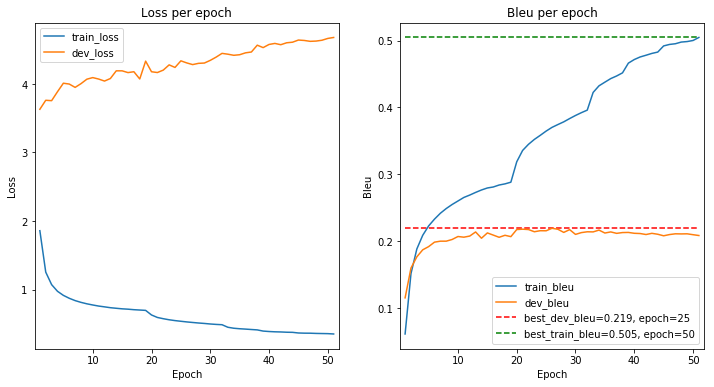

In [34]:
plot_train_dev_curves(checkpoint['history'])

Arriba tenemos las curvas de loss por epoch y bleu por epoch.
Hay un patrón algo extraño que aún no entiendo bien por qué pasa. Por un lado la dev_loss empeora con el tiempo, sin embargo el dev_bleu sí mejora (al menos por un tiempo hasta que se queda estancado en torno al 0.2, con un peak de 0.219 en la época 25). Por su parte, el train_loss siempre baja y el train_blue siempre sube. Esto parece indicar un sobreajuste, en el sentido que el modelo sigue aprendiendo del train pero esto no se ve reflejado en mejoras en el set de dev. Sin embargo, no podemos descartar de plano que, si dejamos el modelo entrenando harto rato más, quizás se encuentre una nueva solución en el espacio de hipótesis mucho mejor y que la generalización al dev set mejore harto más. Pero si tuviese que apostar, diría que probablemente no va a mejorar mucho más en su generalización al set de dev.

# Actividad 6

ACLARACIÓN: dado que por alguna extraña razón la loss crecía en vez de bajar en validación, me vi obligado a usar el BLEU score como criterio para escoger los mejores pesos, que igual tiene mucho sentido ya que esa es la métrica que al fin y al cabo queremos optimizar.

In [78]:
def append_cleaned_sentences_and_bleu_score(
    batch_src_sentences,
    batch_dst_gt_sentences,
    batch_dst_pred_sentences,
    smoothing_function,    
    src_sentences_list,
    dst_gt_sentences_list,
    dst_pred_sentences_list,
    bleu_scores_list,
):    
    batch_size = batch_src_sentences.shape[0]
    batch_blue = 0
    for i in range(batch_size):
        clean_src = [t for t in batch_src_sentences[i] if t >= 4]
        clean_dst_gt = [t for t in batch_dst_gt_sentences[i] if t >= 4]
        clean_dst_pred = [t for t in batch_dst_pred_sentences[i] if t >= 4]
        bleu = sentence_bleu((clean_dst_gt,), clean_dst_pred, smoothing_function=smoothing_function)
        src_sentences_list.append(clean_src)
        dst_gt_sentences_list.append(clean_dst_gt)
        dst_pred_sentences_list.append(clean_dst_pred)
        bleu_scores_list.append(bleu)
        batch_blue += bleu
    return batch_blue / batch_size

def test_model(nmt, checkpoint, criterion, dataloader):    
    
    smoothing_function = SmoothingFunction().method1
    best_wts = checkpoint['best_wts']
    nmt.load_state_dict(best_wts)
    nmt.eval()

    running_loss = 0.0
    running_bleu = 0
    running_count = 0
    since = time.time()
    
    src_sentences_list = []
    dst_gt_sentences_list = []
    dst_pred_sentences_list = []
    bleu_scores_list = []

    with torch.set_grad_enabled(False):
        
        for batch_idx, batch_dict in enumerate(dataloader):
            
            src_sentences = batch_dict['src'].to(DEVICE)
            src_lengths = batch_dict['src_lengths'].to(DEVICE)
            dst_sentences = batch_dict['dst'].to(DEVICE)
            dst_lengths = batch_dict['dst_lengths'].to(DEVICE)
            batch_size = src_sentences.size(0)
            output = nmt.eval_forward(
                src_sentences,
                src_lengths,
                dst_lengths)

            batch_loss = criterion(output.view(-1,output.shape[-1]),
                             dst_sentences.view(-1))
            batch_bleu = append_cleaned_sentences_and_bleu_score(src_sentences.cpu().numpy(),
                                                                 dst_sentences.cpu().numpy(),
                                                                 output.argmax(-1).cpu().numpy(),
                                                                 smoothing_function,
                                                                 src_sentences_list,
                                                                 dst_gt_sentences_list,
                                                                 dst_pred_sentences_list,
                                                                 bleu_scores_list)
            # statistics
            running_loss += batch_loss.item() * batch_size
            running_bleu += batch_bleu * batch_size
            running_count += batch_size

            if (batch_idx % 10 == 0 or batch_idx + 1 == len(dataloader)):
                elapsed_time = time.time() - since
                print("Batch: %d/%d, running_loss=%.5f, running_bleu=%.5f, elapsed_time=%.0fm %.0fs" % (
                    batch_idx+1, len(dataloader),
                    running_loss/running_count,
                    running_bleu/running_count,
                    elapsed_time // 60, elapsed_time % 60,
                ), end="\r", flush=True)

    print()
    avg_loss = running_loss / running_count
    avg_bleu = running_bleu / running_count
    assert abs(avg_bleu - sum(bleu_scores_list) / len(bleu_scores_list)) < 1e-8
    elapsed_time = time.time() - since
    print('Test complete in {:.0f}m {:.0f}s'.format(
        elapsed_time // 60, elapsed_time % 60))
    print('Test loss: {:4f}\t Test bleu: {:4f}'.format(avg_loss, avg_bleu))    
    
    return dict(
        src_sentences_list = src_sentences_list,
        dst_gt_sentences_list = dst_gt_sentences_list,
        dst_pred_sentences_list = dst_pred_sentences_list,
        bleu_scores_list = bleu_scores_list,
    )

def display_examples(src_sentences_list, dst_gt_sentences_list, dst_pred_sentences_list, bleu_scores_list,
                     ids2tokens_func, src_id2token, dst_id2token,
                     top_k=5, worst_k=5, random_k=5, min_src_length=0):
    
    indexes = [i for i in range(len(bleu_scores_list)) if len(src_sentences_list[i]) >= min_src_length]
    indexes.sort(key=lambda i : bleu_scores_list[i], reverse=True)
    n = len(indexes)
    
    if top_k > 0:        
        print('=========== TOP %d translations ===============\n' % (top_k))        
        for i in range(top_k):
            j = indexes[i]
            src_sentence = ids2tokens_func(src_id2token, src_sentences_list[j])
            dst_gt_sentence = ids2tokens_func(dst_id2token, dst_gt_sentences_list[j])
            dst_pred_sentence = ids2tokens_func(dst_id2token, dst_pred_sentences_list[j])
            bleu = bleu_scores_list[j]
            print('******** top %d (bleu_score = %.4f) *******' % (i+1, bleu))
            print('--- SOURCE:\n', src_sentence)
            print('--- MODEL:\n', dst_pred_sentence)
            print('--- GT:\n', dst_gt_sentence)
            print()
    
    if worst_k > 0:        
        print('=========== WORST %d translations ===============\n' % (worst_k))        
        for i in range(1, worst_k+1):
            j = indexes[-i]
            src_sentence = ids2tokens_func(src_id2token, src_sentences_list[j])
            dst_gt_sentence = ids2tokens_func(dst_id2token, dst_gt_sentences_list[j])
            dst_pred_sentence = ids2tokens_func(dst_id2token, dst_pred_sentences_list[j])
            bleu = bleu_scores_list[j]
            print('******** worst %d (bleu_score = %.4f) *******' % (i, bleu))
            print('--- SOURCE:\n', src_sentence)
            print('--- MODEL:\n', dst_pred_sentence)
            print('--- GT:\n', dst_gt_sentence)
            print()

    if random_k > 0:        
        print('=========== Random %d translations ===============\n' % (random_k))
        random_idxs = set()
        while len(random_idxs) < random_k:
            i = random.randint(0, n-1)
            if i in random_idxs:
                continue
            if i < top_k or i >= n - worst_k:
                continue
            random_idxs.add(i)

        for i in random_idxs:
            j = indexes[i]
            src_sentence = ids2tokens_func(src_id2token, src_sentences_list[j])
            dst_gt_sentence = ids2tokens_func(dst_id2token, dst_gt_sentences_list[j])
            dst_pred_sentence = ids2tokens_func(dst_id2token, dst_pred_sentences_list[j])
            bleu = bleu_scores_list[j]
            print('******** random %d (bleu_score = %.4f) *******' % (i+1, bleu))
            print('--- SOURCE:\n', src_sentence)
            print('--- MODEL:\n', dst_pred_sentence)
            print('--- GT:\n', dst_gt_sentence)
            print()

### Resultados en test y comentarios

In [39]:
test_result = test_model(nmt, checkpoint, criterion, dataloaders['test'])

Batch: 252/252, running_loss=4.08037, running_bleu=0.20081, elapsed_time=0m 18s
Test complete in 0m 18s
Test loss: 4.080375	 Test bleu: 0.200807


Como vemos, se obtuvo una test loss de 4.08 y un test bleu de 0.2, muy en el orden de los valores obtenidos en el set de validación.

### Traducciones de ejemplo

In [79]:
display_examples(
    test_result['src_sentences_list'],
    test_result['dst_gt_sentences_list'],
    test_result['dst_pred_sentences_list'],
    test_result['bleu_scores_list'],
    test_dataset.ids2tokens,
    test_dataset.src_id2token,
    test_dataset.dst_id2token,
    top_k = 2,
    worst_k=3,
    random_k = 5,
    min_src_length = 20,
)

=========== TOP 2 translations ===============

******** top 1 (bleu_score = 0.8253) *******
--- SOURCE:
 But at the same time, it's been increasingly frustrating  because we have only started to measure the damage that we have done.
--- MODEL:
 Pero al mismo tiempo, ha sido cada vez ms frustrante porque solo hemos comenzado a medir el dao que hemos hecho.
--- GT:
 Pero al mismo tiempo, ha sido cada vez ms frustrante porque solo hemos estado empezando a medir el dao que hemos hecho.

******** top 2 (bleu_score = 0.7771) *******
--- SOURCE:
 They wanted nothing to do with this film, mainly because they would have no control,  they would have no control over the final product.
--- MODEL:
 Ellos queran que no queran nada que ver con esta pelcula, principalmente porque no tendran control, no tendran control sobre el producto final.
--- GT:
 No queran tener nada que ver con esta pelcula, principalmente porque no tendran control, no tendran control sobre el producto final.

=========== WORST

Arriba hay 5 traducciones de ejemplo (las 2 mejores y las 3 peores), todas con un src_length >= 20. Las escogí porque quería ver los mejores casos y los peores casos con un largo desafiante (20 o más). También agregué 5 ejemplos adicionales muestreados aleatoriamente (también con src_lenth >= 20) por un tema de curiosidad, pero el lector puede limitarse a los primeros 5 ejemplos si así lo desea.

# Actividad 7
### Limitaciones del modelo

1. **Falta usar máscaras para ignorar el padding**: Cuando el **decoder** calcula los coeficientes de atención sobre los hidden states del **encoder**, falta aplicar una máscara para ignorar los hidden states del **encoder** asociados a los tokens de padding. Explicación: el encoder retorna un tensor con todos los hidden states de las oraciones del lenguaje de origen, ajustado al tamaño de la oración más larga, y los hidden states de las oraciones más cortas son rellenados por la derecha con vectores de puros 0s. Al momento de calcular la softmax, estos hidden states de relleno no son ignorados (tienen un peso no normalizado de $e^0 = 1$ que no es 0) lo cual puede meter ruido. Sería más correcto aplicar una máscara para ignorar el padding y forzar que la atención se distribuya sobre la parte relevante de la oración de origen.

2. **Se pierde vocabulario**: al usar un threshold de frecuencia, uno está forzado a ignorar palabras y por ende perder vocabulario. Por el otro lado, si permitimos que se usen todas las palabras, el vocabulario resultante puede ser muy grande y habría que aprender demasiados word embeddings. Una forma de resolver ambos problemas es deshacerse de los word-embeddings por completo y trabajar a un nivel más atómico. Ejemplos de esto son trabajar a nivel de caracteres (_character-level_ embeddings) o un nivel intermedio (_word-piece_ embeddings, Byte-Pair Encoding).

3. **Atrasado respecto al estado del arte**: Los modelos estado de arte actuales en NLP están basados de una u otra manera en el Transformer (del paper Attention is All You Need). La ventaja del transformer es que puede procesar secuencias completas en paralelo y encontrar relaciones entre elementos de una secuencia en O(1) pasos, mientras que modelos recurrentes como la LSTM no son paralelizables (hay que iterar por cada elemento de la secuencia un paso a la vez) y además es más difícil relacionar elementos distantes de una secuencia (debido a los muchos pasos intermedios antes de que la información de un extremo llegue al otro extremo en una secuencia).